# Reinforcement Learning Project

## Setup

To be able to run this notebook properly please make sure to install the pettingzoo package and dependencies. This can be done by running the following command

`pip install pettingzoo[mpe]`

### Imports

In [1]:
from pettingzoo.mpe import simple_world_comm_v2, simple_push_v2
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint
from matplotlib import pyplot as plt
import time
import datetime

### Environment Initialisation

In [2]:
MAX_CYCLES = 50
# Keep as a multiple of 10
NUM_OF_EPISODES = 500
MEANING_OF_LIFE = 42
ENVIRONMENT_NAME = "simple_world_comm"
# ENVIRONMENT_NAME = "simple_push"

env = simple_world_comm_v2.env(num_good=2, num_adversaries=4, num_obstacles=1,
                num_food=2, max_cycles=MAX_CYCLES, num_forests=2, continuous_actions=False)

# env = simple_push_v2.env(max_cycles=25, continuous_actions=False)


env.reset(seed=MEANING_OF_LIFE)
print(f"Agents: {env.agents}")
print()
agent_mapping = {k: v for v, k in enumerate(env.agents)}
inv_agent_map = {v: k for k, v in agent_mapping.items()}
NUM_OF_AGENTS = len(env.agents)


Agents: ['leadadversary_0', 'adversary_0', 'adversary_1', 'adversary_2', 'agent_0', 'agent_1']



### Policy Function

In [3]:
def random_policy(actions):
    return random.randint(0, actions-1)

### Inspection Functions

A collection of inspection functions to help minimise clutter in the training loop below.

In [4]:
def matching_agent_only(agent, desired_agent, function, function_args):
#     To use this function, pass the agent and desired agent as the first two arguments,
#     then pass the function reference and the arguments for the function as a tuple for the final argument.
    if agent == desired_agent:
        function(*function_args)


def print_agent_rewards(agent, reward):
    print(f"{agent}:{reward}")
    
def print_agent_state(agent, observation):
    print(f"{agent}: {observation}")
    
def print_iter_info(agent,observation,reward,done,info):
    print(f"Current Agent: {agent}")
    print(f"Obs: {observation}")
    print(f"Rew: {reward}")      
    print(f"Done: {done}")
    print(f"Info: {info}")

def get_current_step(env):
    return env.env.env.steps

def np_array_no_e(array):
    np.set_printoptions(suppress=True)
    print(array)
    np.set_printoptions(suppress=False)

### Running the environment

The `env.render(mode='human')` call will pop open a new window that shows the environment at each time step.

On my machine at least this window can only be closed while the cell is running but then freezes and is unable to be closed afterwards. In these cases restarting the kernel closed the window and any others which may have been opened due to running the cell multiple times.

Eventually running the cell enough times without restarting the kernal will cause the render call to throw an exception and not run. In this case just restart the kernal and it will begin working again.

In [5]:
class agent_stub:
    def __init__(self, temp, temp_two):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return random_policy(env.action_space(agent).n)
    
    def save_action_state(self, action, state):
        pass
    
    def save_history(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass

    def update_target_network_weights(self):
        pass


In [6]:
class good_agent_stub:
    def __init__(self):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return 0
    
    def save_action_state(self, action, state):
        pass
    
    def save_memory(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass
    
    def update_target_network_weights(self):
        pass

In [7]:
class agent:
    
    def __init__(self, agent_name, state_size, epsilon=1, epsilon_min = 0.1, 
                 epsilon_decay = 0.975, batch_size=8, learning_decay_rate = 0.95,
                target_update_steps = 10, action_space=5, experience_replay = True):
        
        self.state_size = state_size
        self.action_space = 5
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.agent_name = agent_name
        self.history = []
        self.action_taken = None
        self.previous_state = None
        self.batch_size = batch_size
        self.gamma = learning_decay_rate
        self.target_update_steps = target_update_steps
        self.update_target_network_weights()
        self.replay_enabled = experience_replay
    
    def build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(self.state_size, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(self.action_space, activation="softmax"))
        model.compile(loss=keras.losses.Huber(), 
                      optimizer = keras.optimizers.Adam(learning_rate=0.00025))
 
        return model
    
    def exploration_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)
            
    def save_model(self, agent_filename, target_filename):
        self.model.save(agent_filename+".h5")
        self.target_model.save(target_filename+".h5")
    
    def load_model(self, agent_filename, target_filename):
        self.model.load_weights(agent_filename)
        self.target_model.load_weights(target_filename)
        
    def policy(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        action_vals = self.predict(state)
        return np.argmax(action_vals[0])
    
    def save_action_state(self, action, state):
        self.action_taken = action
        self.previous_state = state
        
    def save_history(self, state, reward, done):
        if self.previous_state is None and self.action_taken is None:
            self.previous_state = state
            self.action_taken = 0
        self.history.append((self.previous_state, self.action_taken, reward, state, done))
    
    def get_history(self):
        return self.history
    
    def replay(self):
        if self.replay_enabled:
            if len(self.history) < self.batch_size:
                return
            sample_batch = random.sample(self.history, self.batch_size)
            targets = []
            states = []

            for state, action, reward, next_state, done in sample_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
                target_f = self.predict(state)
                target_f[0][action] = target
                targets.append(target_f[0])
                states.append(state)      
            
#             print(np.asarray(targets).shape)
#             print(np.asarray(states).shape)
            
            self.model.fit(np.asarray(states),np.asarray(targets), epochs=1, verbose=0, batch_size=self.batch_size)
        else:
#             print(self.history[-1])
            state, action, reward, next_state, done = self.history[-1]
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
            target_f = self.predict(state)
            target_f[0][action] = target
            state = np.reshape(state, (1,self.state_size))
            self.model.fit(state,target_f, epochs=1, verbose=0,)
        
        self.exploration_decay()
    
    def get_learning_steps(self):
        return self.learning_steps
    
    def predict(self, state):
#         print(f"Before Reshape: {state}")
        state = np.reshape(state, (1,self.state_size))
#         print(f"After Reshape: {state}")
        return self.model.predict(state)

    def target_predict(self, state):
        state = np.reshape(state, (1,self.state_size))
        return self.target_model.predict(state)

    def update_target_network_weights(self):
        self.target_model.set_weights(self.model.get_weights())

In [8]:
env.reset(seed=MEANING_OF_LIFE)
reward_array = np.zeros((NUM_OF_EPISODES,len(env.agents)))

cumulative_reward = np.zeros(len(env.agents))
i = 0
agent_models = {}

ten_percent_episodes = int(NUM_OF_EPISODES/10)
save_models = True


# Creates the models. Models are shared between multiple adversaries and agents so for the first one of
# each type it creates the models while subsequent agents get the reference to the model passed as their
# 'model'
for key in agent_mapping:
    if key == "leadadversary_0":
        agent_models[key] = agent(key, env.observation_space(key)._shape[0], 
                                  action_space=env.action_space("leadadversary_0").n)
    elif "adversary" in key:
        if key == "adversary_0":    
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["adversary_0"]
    elif "agent" in key:
        if "agent_0" == key:
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["agent_0"]

# for key in agent_mapping:
#         agent_models[key] = agent_stub()

cycle_scores = np.zeros((len(env.agents), NUM_OF_EPISODES,MAX_CYCLES+1))
step = -1
episode_times = []  


for episode in range(NUM_OF_EPISODES):
    print(f"Episode {episode+1} out of {NUM_OF_EPISODES}")
    env.reset(seed=MEANING_OF_LIFE)
    cumulative_reward.fill(0)
    if episode > 0:
        print(f"Time taken for previous episode: {time.time()-episode_start_time}")
    episode_start_time = time.time()
    
    for agent in env.agent_iter():
        step_time = time.time()    
        if step != get_current_step(env):
#             print(f"Step: {get_current_step(env)}/{MAX_CYCLES}")
            step = get_current_step(env)
#         print(agent)
        
        observation, reward, done, info = env.last()
        cumulative_reward[agent_mapping[agent]] += reward
        cycle_scores[agent_mapping[agent]][episode][step] = reward
        
        agent_models[agent].save_history(observation, reward, done)
        
        if agent in ["leadadversary_0", "adversary_2", "agent_1"] or ENVIRONMENT_NAME == "simple_push":
            agent_models[agent].replay()
            if (step % agent_models[agent].target_update_steps) == 0:
                agent_models[agent].update_target_network_weights()

            if (episode % ten_percent_episodes == 0) and save_models:
                agent_models[agent].save_model(
                    ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_model",
                ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_target_model")

            
    #     Renders the environment for each step in a seperate window.        
#         env.render(mode='human')
    
    
    #     Steps the environment forward.
        if done:
            env.step(None)
            reward_array[episode,agent_mapping[agent]] = cumulative_reward[agent_mapping[agent]]
        else:
            action_to_take = agent_models[agent].policy(observation)
            env.step(action_to_take)
            agent_models[agent].save_action_state(action_to_take, observation)
        
#         print(f"Step Time: {time.time()-step_time}")
   

    episode_time = time.time()-episode_start_time
    episode_times.append(episode_time)
    print(f"Episode Time: {episode_time}")


Episode 1 out of 500
Episode Time: 78.38368439674377
Episode 2 out of 500
Time taken for previous episode: 78.38418436050415
Episode Time: 79.38475251197815
Episode 3 out of 500
Time taken for previous episode: 79.38475251197815
Episode Time: 79.29369854927063
Episode 4 out of 500
Time taken for previous episode: 79.29369854927063
Episode Time: 80.03921818733215
Episode 5 out of 500
Time taken for previous episode: 80.03921818733215
Episode Time: 79.01592326164246
Episode 6 out of 500
Time taken for previous episode: 79.01592326164246
Episode Time: 79.01306223869324
Episode 7 out of 500
Time taken for previous episode: 79.01353430747986
Episode Time: 79.09053707122803
Episode 8 out of 500
Time taken for previous episode: 79.09053707122803
Episode Time: 79.37140154838562
Episode 9 out of 500
Time taken for previous episode: 79.37140154838562
Episode Time: 79.18645858764648
Episode 10 out of 500
Time taken for previous episode: 79.1869580745697
Episode Time: 79.22008037567139
Episode 11 

Episode Time: 79.24115562438965
Episode 81 out of 500
Time taken for previous episode: 79.24165654182434
Episode Time: 79.02180695533752
Episode 82 out of 500
Time taken for previous episode: 79.02233934402466
Episode Time: 79.1005048751831
Episode 83 out of 500
Time taken for previous episode: 79.10103011131287
Episode Time: 79.44832611083984
Episode 84 out of 500
Time taken for previous episode: 79.44882583618164
Episode Time: 79.55268025398254
Episode 85 out of 500
Time taken for previous episode: 79.55317401885986
Episode Time: 79.7776927947998
Episode 86 out of 500
Time taken for previous episode: 79.7781925201416
Episode Time: 79.41702365875244
Episode 87 out of 500
Time taken for previous episode: 79.41755175590515
Episode Time: 80.10067915916443
Episode 88 out of 500
Time taken for previous episode: 80.10067915916443
Episode Time: 79.33751726150513
Episode 89 out of 500
Time taken for previous episode: 79.33751726150513
Episode Time: 78.9417564868927
Episode 90 out of 500
Time 

Episode Time: 79.51315712928772
Episode 159 out of 500
Time taken for previous episode: 79.51365733146667
Episode Time: 78.89486980438232
Episode 160 out of 500
Time taken for previous episode: 78.89537024497986
Episode Time: 80.27335000038147
Episode 161 out of 500
Time taken for previous episode: 80.27384948730469
Episode Time: 79.37159895896912
Episode 162 out of 500
Time taken for previous episode: 79.37209844589233
Episode Time: 80.05387949943542
Episode 163 out of 500
Time taken for previous episode: 80.05437994003296
Episode Time: 79.60789227485657
Episode 164 out of 500
Time taken for previous episode: 79.60789227485657
Episode Time: 79.4811794757843
Episode 165 out of 500
Time taken for previous episode: 79.4816792011261
Episode Time: 79.31046223640442
Episode 166 out of 500
Time taken for previous episode: 79.31096243858337
Episode Time: 79.50641965866089
Episode 167 out of 500
Time taken for previous episode: 79.50641965866089
Episode Time: 79.72277092933655
Episode 168 out 

Episode Time: 79.15766286849976
Episode 237 out of 500
Time taken for previous episode: 79.15816450119019
Episode Time: 79.47984457015991
Episode 238 out of 500
Time taken for previous episode: 79.48034429550171
Episode Time: 79.67602443695068
Episode 239 out of 500
Time taken for previous episode: 79.67652344703674
Episode Time: 79.10967540740967
Episode 240 out of 500
Time taken for previous episode: 79.11017537117004
Episode Time: 79.3447630405426
Episode 241 out of 500
Time taken for previous episode: 79.3452627658844
Episode Time: 79.59126472473145
Episode 242 out of 500
Time taken for previous episode: 79.59126472473145
Episode Time: 78.7818124294281
Episode 243 out of 500
Time taken for previous episode: 78.7818124294281
Episode Time: 79.45233917236328
Episode 244 out of 500
Time taken for previous episode: 79.45284080505371
Episode Time: 79.34917092323303
Episode 245 out of 500
Time taken for previous episode: 79.3496527671814
Episode Time: 79.06895160675049
Episode 246 out of 

Episode Time: 79.59412264823914
Episode 315 out of 500
Time taken for previous episode: 79.59462237358093
Episode Time: 79.1830723285675
Episode 316 out of 500
Time taken for previous episode: 79.1830723285675
Episode Time: 79.3119707107544
Episode 317 out of 500
Time taken for previous episode: 79.3119707107544
Episode Time: 79.47343277931213
Episode 318 out of 500
Time taken for previous episode: 79.47393250465393
Episode Time: 79.71692490577698
Episode 319 out of 500
Time taken for previous episode: 79.71742463111877
Episode Time: 79.1542637348175
Episode 320 out of 500
Time taken for previous episode: 79.15476322174072
Episode Time: 79.2584547996521
Episode 321 out of 500
Time taken for previous episode: 79.25895476341248
Episode Time: 79.5094063282013
Episode 322 out of 500
Time taken for previous episode: 79.50990581512451
Episode Time: 79.60781908035278
Episode 323 out of 500
Time taken for previous episode: 79.60834407806396
Episode Time: 79.53392744064331
Episode 324 out of 50

Episode Time: 79.0323486328125
Episode 393 out of 500
Time taken for previous episode: 79.03284883499146
Episode Time: 79.30519890785217
Episode 394 out of 500
Time taken for previous episode: 79.3056972026825
Episode Time: 79.13117551803589
Episode 395 out of 500
Time taken for previous episode: 79.13170266151428
Episode Time: 79.16562294960022
Episode 396 out of 500
Time taken for previous episode: 79.16612386703491
Episode Time: 79.41029191017151
Episode 397 out of 500
Time taken for previous episode: 79.41076135635376
Episode Time: 79.4388427734375
Episode 398 out of 500
Time taken for previous episode: 79.43934321403503
Episode Time: 79.40462303161621
Episode 399 out of 500
Time taken for previous episode: 79.40462303161621
Episode Time: 79.53995680809021
Episode 400 out of 500
Time taken for previous episode: 79.54045677185059
Episode Time: 79.56309580802917
Episode 401 out of 500
Time taken for previous episode: 79.56359577178955
Episode Time: 85.07518434524536
Episode 402 out o

Episode Time: 82.21131443977356
Episode 471 out of 500
Time taken for previous episode: 82.2118136882782
Episode Time: 81.09302020072937
Episode 472 out of 500
Time taken for previous episode: 81.09351539611816
Episode Time: 80.90282964706421
Episode 473 out of 500
Time taken for previous episode: 80.90335392951965
Episode Time: 79.5511372089386
Episode 474 out of 500
Time taken for previous episode: 79.55163717269897
Episode Time: 82.6546995639801
Episode 475 out of 500
Time taken for previous episode: 82.65520477294922
Episode Time: 82.3596556186676
Episode 476 out of 500
Time taken for previous episode: 82.36013126373291
Episode Time: 82.46547150611877
Episode 477 out of 500
Time taken for previous episode: 82.46597194671631
Episode Time: 82.0110604763031
Episode 478 out of 500
Time taken for previous episode: 82.0115966796875
Episode Time: 82.15211415290833
Episode 479 out of 500
Time taken for previous episode: 82.15211415290833
Episode Time: 82.21295285224915
Episode 480 out of 5

In [9]:
# Closs the render window.
# env.close()
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Print Reward Array

In [10]:
# np_array_no_e(reward_array)

x = 1

with open(f"{ENVIRONMENT_NAME}_random_{NUM_OF_EPISODES}ep.csv", "w+") as f:
    f.write("episode,lead_adversary,adversary_0,adversary_1,adversary_2,agent_0,agent_1\n")
    for j, i in enumerate(reward_array):
        f.write(f"{x}, {i[0]},{i[1]}, {i[2]},{i[3]},{i[4]},{i[5]}\n")
        x += 1

In [11]:
# np_array_no_e(cycle_scores[0])
# print()
# print()
# print()
# np_array_no_e(cycle_scores[1])
# np_array_no_e(cycle_scores[1].sum(axis=1))

In [12]:
print(str(datetime.timedelta(seconds=np.mean(episode_times))))

0:01:19.770791


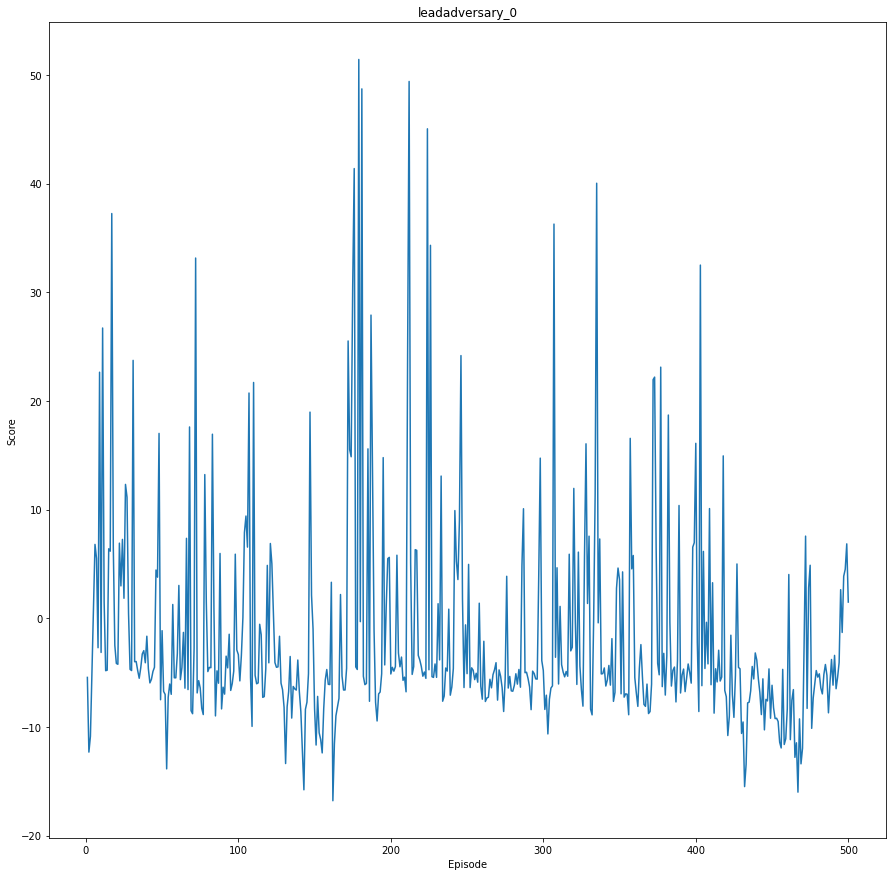

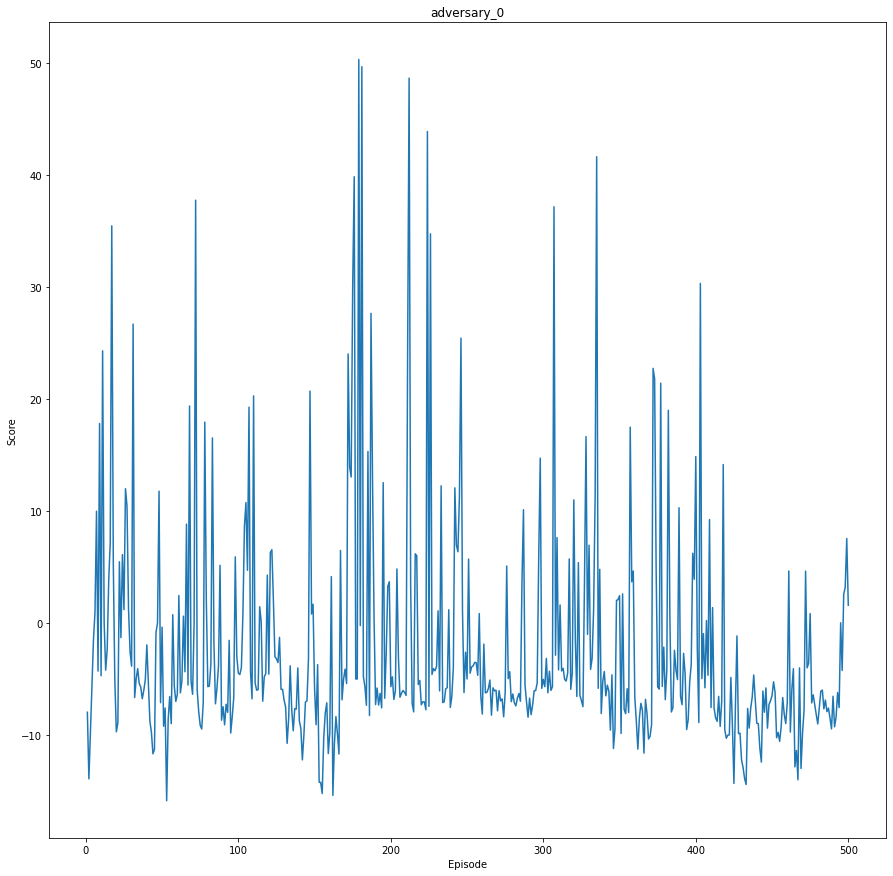

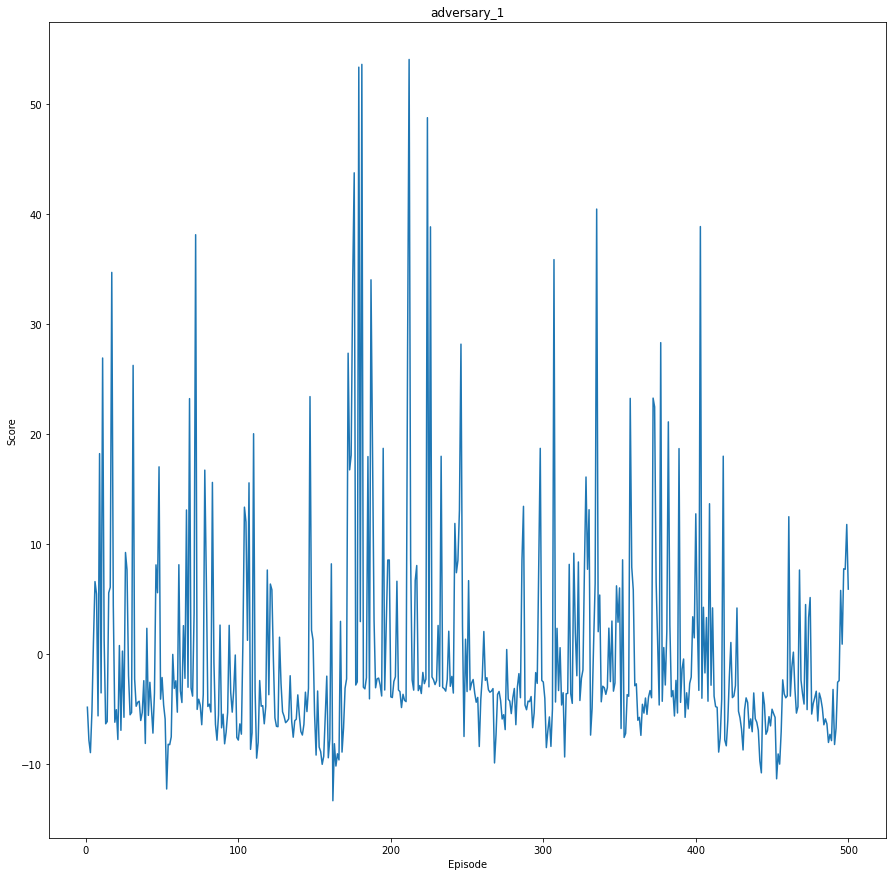

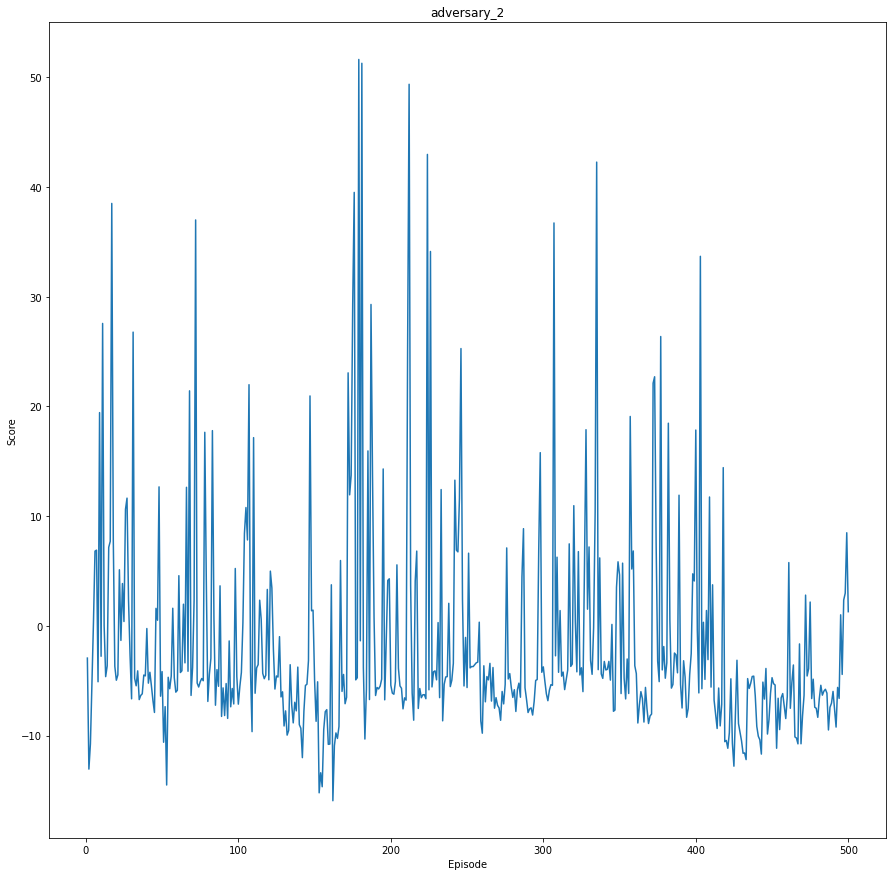

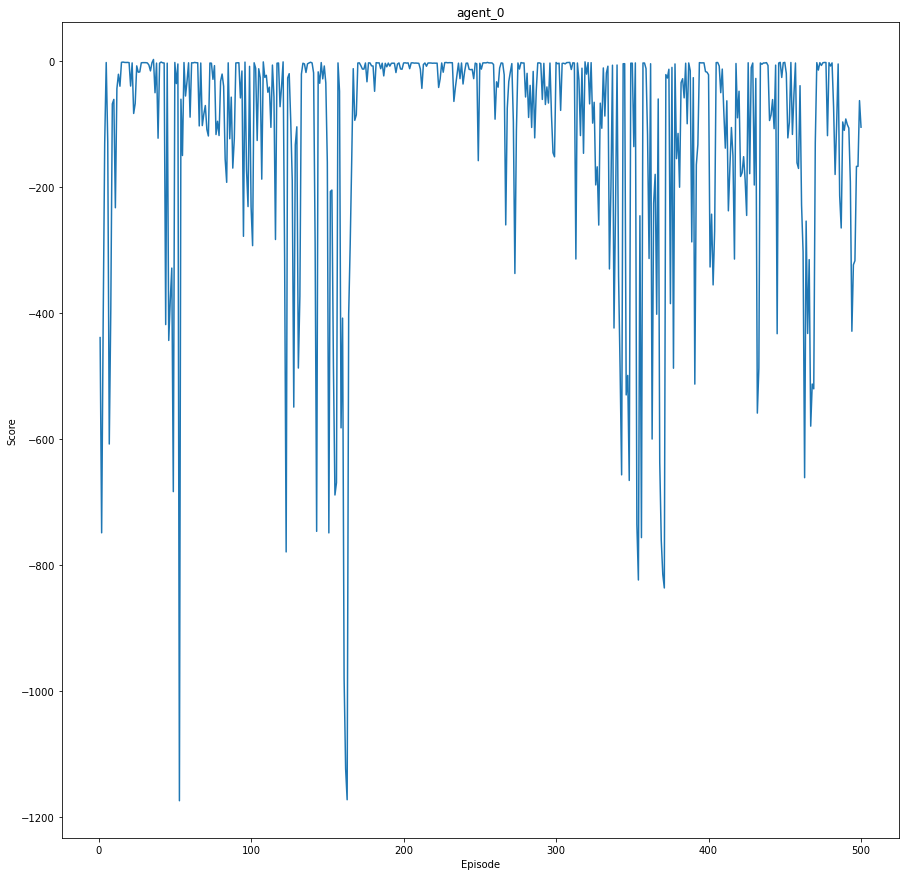

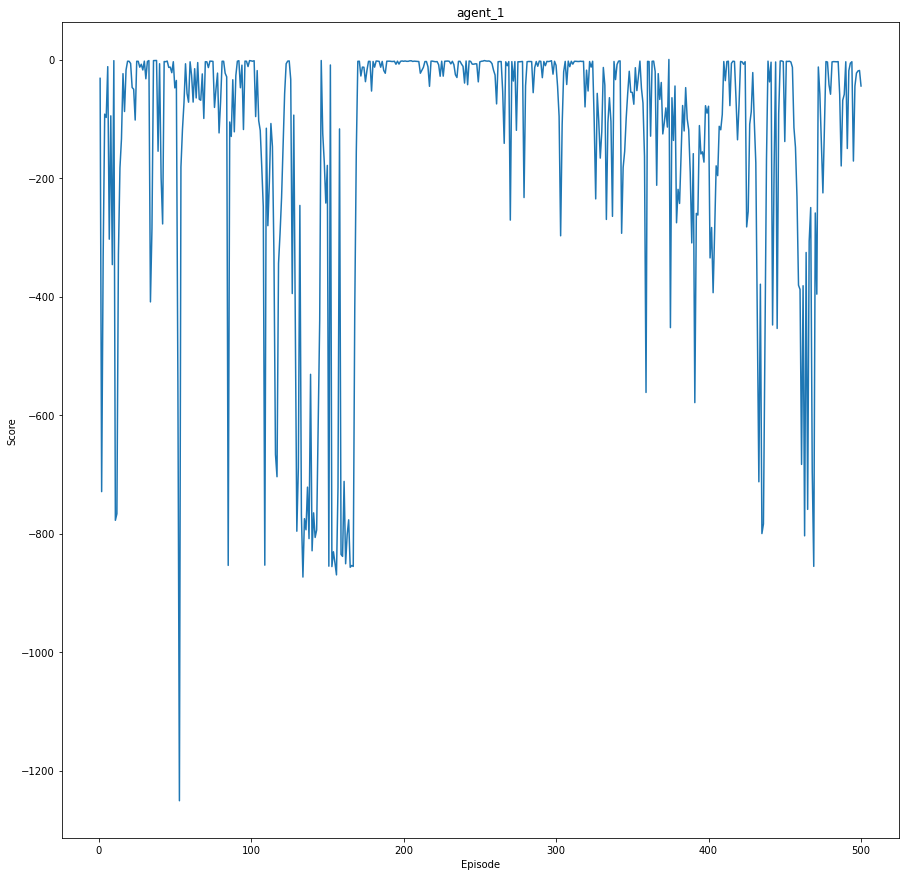

In [13]:
for i in range(0,NUM_OF_AGENTS):
    plt.figure(figsize=(15,15))
    plt.plot(range(1,NUM_OF_EPISODES+1), reward_array[:,i])
    plt.title(inv_agent_map[i])
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.savefig(f"{ENVIRONMENT_NAME}_{inv_agent_map[i]}_random_"+str(NUM_OF_EPISODES)+"_episodes.png")
    plt.show()

In [14]:
print(agent_models)

{'leadadversary_0': <__main__.agent object at 0x0000025CC6E78BE0>, 'adversary_0': <__main__.agent object at 0x0000025CC6ED6130>, 'adversary_1': <__main__.agent object at 0x0000025CC6ED6130>, 'adversary_2': <__main__.agent object at 0x0000025CC6ED6130>, 'agent_0': <__main__.agent object at 0x0000025CCDA34F70>, 'agent_1': <__main__.agent object at 0x0000025CCDA34F70>}


In [15]:
pprint(vars(env.env.env))

{'_agent_selector': <pettingzoo.utils.agent_selector.agent_selector object at 0x0000025CC6ECB400>,
 '_cumulative_rewards': {},
 '_index_map': {'adversary_0': 1,
                'adversary_1': 2,
                'adversary_2': 3,
                'agent_0': 4,
                'agent_1': 5,
                'leadadversary_0': 0},
 '_skip_agent_selection': None,
 'action_spaces': {'adversary_0': Discrete(5),
                   'adversary_1': Discrete(5),
                   'adversary_2': Discrete(5),
                   'agent_0': Discrete(5),
                   'agent_1': Discrete(5),
                   'leadadversary_0': Discrete(20)},
 'agent_selection': 'leadadversary_0',
 'agents': [],
 'continuous_actions': False,
 'current_actions': [1, 3, 2, 1, 4, 3],
 'dones': {},
 'infos': {},
 'local_ratio': None,
 'max_cycles': 50,
 'metadata': {'is_parallelizable': True,
              'name': 'simple_world_comm_v2',
              'render_fps': 10,
              'render_modes': ['human', 'rgb_arr

In [16]:
if save_models:
    agent_models["adversary_2"].save_model(
        ENVIRONMENT_NAME+"_adversary_2_"+str(NUM_OF_EPISODES)+"_ep_final_model", 
        ENVIRONMENT_NAME+"_adversary_2_"+str(NUM_OF_EPISODES)+"_final_target_model")

In [17]:
if save_models:
    agent_models["agent_1"].save_model(
        ENVIRONMENT_NAME+"_agent_1_"+str(NUM_OF_EPISODES)+"_final_model", 
        ENVIRONMENT_NAME+"_agent_1_"+str(NUM_OF_EPISODES)+"_final_target_model")

In [18]:
if save_models:
    agent_models["leadadversary_0"].save_model(
        ENVIRONMENT_NAME+"_leadadversary_0_"+str(NUM_OF_EPISODES)+"_ep_final_model", 
        ENVIRONMENT_NAME+"_leadadversary_0_"+str(NUM_OF_EPISODES)+"_final_target_model")